Analysis of CDC w.r.t. dataset

In [11]:
import pandas as pd
import numpy as np
from conformal_data_cleaning.cleaner.autogluon import ConformalAutoGluonCleaner

def is_categorical(
    column: pd.Series,
    n_samples: int = 1000,
    max_unique_fraction: float = 0.2,
    random_generator: None = None,
) -> bool:
    """Check if `column` type is categorical.

    A heuristic to check whether a `column` is categorical:
    a column is considered categorical (as opposed to a plain text column)
    if the relative cardinality is `max_unique_fraction` or less.

    Args:
        column (ArrayLike): pandas `Series` containing strings
        n_samples (int, optional): number of samples used for heuristic. Defaults to 1000.
        max_unique_fraction (float, optional): maximum relative cardinality. Defaults to 0.2.
        random_generator (Generator, optional): random generator. Defaults to None.

    Returns:
        bool: `True` if the column is categorical according to the heuristic.
    """
    if random_generator is None:
        random_generator = np.random.default_rng()

    column = np.array(column)
    n_samples = min(n_samples, len(column))
    values, counts = np.unique(column, return_counts=True)
    sample = random_generator.choice(a=values, p=counts / counts.sum(), size=n_samples)
    unique_samples = np.unique(sample)

    return unique_samples.shape[0] / n_samples <= max_unique_fraction


def conformal_clean(
    test_df: pd.DataFrame,
    train_df: pd.DataFrame,
    c_level: float,
    njobs: int = 4,
    seed:int = 41
):
    """

    Input: 
        the perturbed dataframe given in the demo
        the alpha value for conformal coverage


    Output:
        Cleaned dataframe
    """
    model_hps = {"hyperparameters": {"RF": {}}}
    cleaner: ConformalAutoGluonCleaner = ConformalAutoGluonCleaner(confidence_level=c_level, seed = seed)
    fit_cleaner = cleaner.fit(train_df, ci_ag_fit_params=model_hps)
    cleaned_test_df, cleaned_mask = fit_cleaner.transform(test_df)

    # Analysis
    coverages = []
    empty_set_fractions = []
    average_set_sizes = []
    relative_average_set_sizes = []

    # Get categorical and numerical columns
    categorical_cols = [c for c in train_df.columns if is_categorical(train_df[c])]
    numerical_cols = [c for c in train_df.columns if not is_categorical(train_df[c])]

    for column_name, prediction_sets in cleaner._prediction_sets.items():
        if column_name in categorical_cols:
            cardinality = len(train_df[column_name].unique())
            true_value_in_prediction_set = np.any(
                prediction_sets == test_df[column_name].to_numpy()[:, np.newaxis], axis=1
            )
            coverages.append(true_value_in_prediction_set.mean())

            average_set_sizes.append((~pd.DataFrame(prediction_sets).isna()).sum(axis=1).mean())
            relative_average_set_sizes.append(average_set_sizes[-1] / cardinality)
            empty_set_fractions.append(((~pd.DataFrame(prediction_sets).isna()).sum(axis=1) == 0).mean())

        elif column_name in numerical_cols:
            value_range = (
                train_df[column_name].max()
                - train_df[column_name].min()
            )
            true_value_in_prediction_range = (test_df[column_name].to_numpy() >= prediction_sets[:, 0]) & (
                test_df[column_name].to_numpy() <= prediction_sets[:, 1]
            )
            coverages.append(true_value_in_prediction_range.mean())
            average_set_sizes.append((prediction_sets[:, 1] - prediction_sets[:, 0]).mean())
            relative_average_set_sizes.append(average_set_sizes[-1] / value_range)
            empty_set_fractions.append(((prediction_sets[:, 1] - prediction_sets[:, 0]) == 0).mean())


    return cleaned_test_df, cleaned_mask, coverages

In [12]:
import pandas as pd
from sklearn.model_selection import train_test_split

df = pd.read_csv("44969.csv")

y = np.ones(len(df))

df_train, df_test, y_train, y_test = train_test_split(df, y, test_size=0.2)

In [13]:
import pandas as pd
from tab_err.api.high_level import create_errors_with_config

error_rates = [0.05, 0.1, 0.25]
conf_lvls = [0.9, 0.99, 0.999]

cleaned_dfs = {}

coverage_results = pd.DataFrame(
    columns=["Error Rate", "Confidence Level", "Coverage"]
)

rows = []

for e_rate in error_rates:
    for c_lvl in conf_lvls:
        perturbed_df, error_mask, config = create_errors_with_config(
            df_test,
            error_rate=e_rate,
            seed=1,
        )

        clean_df, clean_mask, coverages = conformal_clean(
            perturbed_df,
            train_df=df_train,
            c_level=c_lvl,
        )

        for cov in coverages:
            rows.append({
                "Error Rate": e_rate,
                "Confidence Level": c_lvl,
                "Coverage": cov,
            })

coverage_results = pd.DataFrame(rows)



/home/chandlernick/BHT/Research/error-demo/.venv/lib/python3.10/site-packages/tab_err/error_type/_error_type.py:67: UserWarning: No scaling function was supplied for WrongUnit, defaulting to multiplication by 10.0.
  return self._apply(data, error_mask, column)
/home/chandlernick/BHT/Research/error-demo/.venv/lib/python3.10/site-packages/tab_err/error_type/_error_type.py:67: UserWarning: self.config.add_delta_value is none, sampling a random delta value uniformly from the range of column: ship_speed.
  return self._apply(data, error_mask, column)
2026-01-15 16:27:22,680 - INFO - conformal_data_cleaning.cleaner.autogluon: Start fitting predictor #1 of 15
2026-01-15 16:27:22,680 - INFO - conformal_data_cleaning.cleaner.autogluon: Start fitting predictor #1 of 15
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.4.0
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #91~22.04.1-Ubuntu

In [15]:
coverage_results

,Error Rate,Confidence Level,Coverage
0,0.05,0.900,0.000000
1,0.05,0.900,0.051948
2,0.05,0.900,0.856305
3,0.05,0.900,0.895685
4,0.05,0.900,0.861751
...,...,...,...
130,0.25,0.999,0.750314
131,0.25,0.999,0.693339
132,0.25,0.999,0.750314
133,0.25,0.999,0.804357


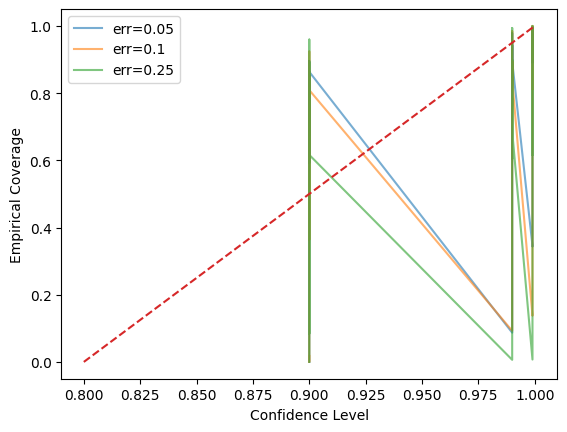

In [18]:
import matplotlib.pyplot as plt

plt.figure()
for err, g in coverage_results.groupby("Error Rate"):
    plt.plot(g["Confidence Level"], g["Coverage"], label=f"err={err}", alpha=0.6)

plt.plot([0.8, 1], [0, 1], linestyle="--")  # ideal calibration
plt.xlabel("Confidence Level")
plt.ylabel("Empirical Coverage")
plt.legend()
plt.show()